In [1]:
import tntorch as tn

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../tacotron2/")
sys.path.insert(0, "../waveglow/")

import librosa
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Audio

from audio.vocoders import griffin_lim
from tacotron2.model import Tacotron2
from tacotron2.layers import TTLSTM
from tacotron2.text import text_to_sequence, sequence_to_text
from waveglow.glow import WaveGlow

%matplotlib inline

In [2]:
# Tacotron 2
TACOTRON_CONFIG=json.load(open('../tacotron2/config.json', 'r'))
TACOTRON_CHECKPT='../checkpoints/tacotron2_statedict.pt'

# Waveglow
WAVEGLOW_CONFIG=json.load(open('../waveglow/config.json', 'r'))
WAVEGLOW_CHECKPT='../checkpoints/waveglow_256channels_ljs_v3.pt'

# Essential
ON_GPU=False
MAX_WAV_VALUE=32768.0
SIGMA=1.1

In [3]:
tacotron2 = Tacotron2(TACOTRON_CONFIG)
checkpt_state_dict = torch.load(TACOTRON_CHECKPT,
                                map_location=lambda storage, loc: storage)['state_dict']
tacotron2.load_state_dict(checkpt_state_dict)
_ = tacotron2.cuda().eval() if ON_GPU else tacotron2.cpu().eval()

print('Number of parameters:', tacotron2.nparams())

Number of parameters: 28193153


In [4]:
list(map(lambda x: x.shape, tacotron2.encoder.lstm.state_dict().values()))

[torch.Size([1024, 512]),
 torch.Size([1024, 256]),
 torch.Size([1024]),
 torch.Size([1024]),
 torch.Size([1024, 512]),
 torch.Size([1024, 256]),
 torch.Size([1024]),
 torch.Size([1024])]

In [5]:
out1, _ = tacotron2.encoder.lstm(torch.randn(4, 100, 512))

In [6]:
ttlstm = TTLSTM(tacotron2.encoder.lstm)

In [7]:
out2, _ = ttlstm(torch.randn(4, 100, 512))

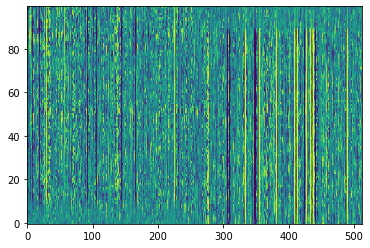

In [8]:
plt.imshow(out1.detach()[0], aspect='auto', origin='bottom');

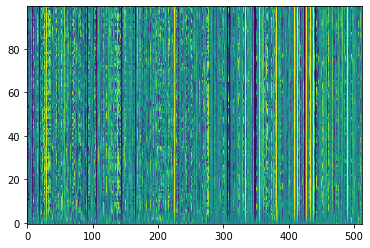

In [9]:
plt.imshow(out2.detach()[0], aspect='auto', origin='bottom');

In [10]:
ttlstm.nparams()

60416

In [11]:
sum(p.numel() for p in tacotron2.encoder.lstm.parameters() if p.requires_grad)

1576960